In [1]:
import os
import sys

import numpy as np
import h5py
import matplotlib.pyplot as plt
from skimage import io, transform
from rich.progress import track
from pystackreg import StackReg
import imageio

sys.path.insert(0, "D:/Research/scripts/paraview_analysis/")
import support as sp
import gif

%matplotlib widget

folder = "D:/Research/Ta_AM-Spalled/Data/3D/"


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
bse_folder = os.path.join(folder, "BSE/")
key_f = lambda x: int(x.replace(".tif", "").replace("Slice", "").replace(bse_folder, ""))
bse_paths = os.listdir(bse_folder)
paths = sorted([os.path.join(bse_folder, path) for path in bse_paths if ".tif" in path], key=key_f)
# bse = np.array([io.imread(path, as_gray=True) for path in paths])
bse = io.imread(paths[0], as_gray=True)
dy = 4050
dx = 4212
slice_y = slice(int(bse.shape[0] / 2 - dy / 2) - 23, int(bse.shape[0] / 2 + dy / 2) - 23)
slice_x = slice(int(bse.shape[1] / 2 - dx / 2) + 100, int(bse.shape[1] / 2 + dx / 2) + 100)


In [ ]:
global_shift = 0
for i in range(len(paths)):
    im = io.imread(paths[i], as_gray=True)
    if i+1 > 212:
        out = np.zeros(im.shape, dtype=im.dtype)
        out[:, 355:] = im[:, :-355]
    else:
        out = im
    if i % 4 == 0:
        global_shift += 1
    if global_shift > 0:
        out[:, :-global_shift] = out[:, global_shift:]
    imageio.imsave(f"D:/Research/Ta_AM-Spalled/Data/3D/BSE/cropped/{i+1}.tiff", out[slice_y, slice_x])

In [ ]:
ebsd_shape = h5py.File(os.path.join(folder, "Ta_AM-Spalled_aligned.dream3d"))["DataContainers/ImageDataContainer/CellData/Image Quality"].shape[1:3]
print(ebsd_shape)

bse_folder = os.path.join(folder, "BSE/cropped/")
key_f = lambda x: int(x.replace(".tiff", "").replace(bse_folder, ""))
bse_paths = os.listdir(bse_folder)
paths = sorted([os.path.join(bse_folder, path) for path in bse_paths if ".tiff" in path], key=key_f)

for i in range(len(paths)):
    raw = io.imread(paths[i], as_gray=True)
    d = transform.resize(raw, ebsd_shape)
    d = np.around(65535 * d/d.max(), 0).astype(np.uint16)
    imageio.imsave(os.path.join(folder, f"BSE/small/{i}.tiff"), d, format="TIFF")


(632, 586)


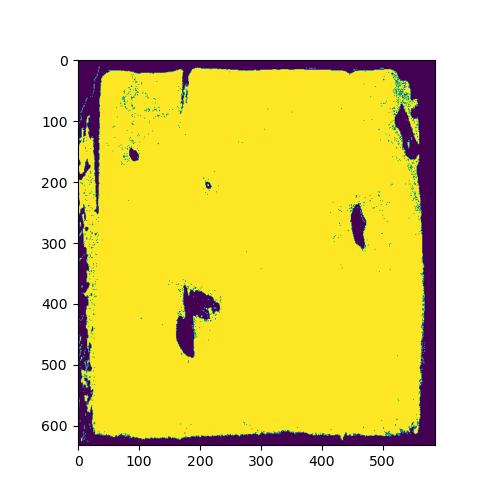

In [12]:
ebsd = h5py.File(os.path.join(folder, "Ta_AM-Spalled_aligned_corrected.dream3d"), "r")
cell_s = "DataContainers/ImageDataContainer/CellData/"
print(ebsd[cell_s+"BSE"][700,9:641,60:646,0].shape)
plt.close("all")
im = np.where(ebsd[cell_s+"Confidence Index"][...] > 0.14, 1, 0)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.imshow(im[211,9:641,60:646,0])
plt.show()


### INSERTING BSE INTO EBSD

In [ ]:
# Read EBSD in
ebsd = h5py.File(os.path.join(folder, "Ta_AM-Spalled_aligned_corrected.dream3d"), "r+")
cell_s = "DataContainers/ImageDataContainer/CellData/"
# Read BSE in
bse_folder = os.path.join(folder, "BSE/small/")
key_f = lambda x: int(x.replace(".tiff", "").replace(bse_folder, ""))
bse_paths = os.listdir(bse_folder)
paths = sorted([os.path.join(bse_folder, path) for path in bse_paths if ".tiff" in path], key=key_f)
bse = np.array([io.imread(path, as_gray=True) for path in paths]).reshape(ebsd[cell_s+"Image Quality"].shape)
ebsd[cell_s+"BSE"][...] = bse
ebsd.close()